# Week 7: LangGraph 에이전트 아키텍처 II - 성찰 메커니즘과 다중 에이전트 시스템

## 과제 개요
- **주제**: "AI 연구팀 시뮬레이터" 구축
- **목표**: 여러 전문 에이전트가 협업하며 자가 개선하는 시스템
- **핵심**: 성찰(Reflection) + 서브그래프(Subgraph) + 다중 에이전트(Multi-Agent)

## 6주차 vs 7주차

| 항목 | 6주차 | 7주차 |
|------|-------|-------|
| 에이전트 | 단일 에이전트 | 다중 에이전트 (3개+) |
| 개선 | 재계획만 | 성찰 + 자가 개선 |
| 구조 | 단일 그래프 | 메인 + 서브그래프 |
| 협업 | 없음 | 순차/병렬 협업 |
| 피드백 | LLM만 | 에이전트 간 피드백 |

## 비유

- **6주차**: "혼자 일하는 똑똑한 직원"
  - 계획 → 실행 → 확인 → 재계획
  
- **7주차**: "서로 피드백하며 협업하는 전문가 팀"
  - 연구원 + 작가 + 비평가가 협력
  - 각자 자기 작업을 평가하고 개선
  - 서로 결과물을 주고받으며 완성도 향상

## AI 연구팀 구조
```
        ┌─────────────┐
        │ Supervisor  │ (감독관)
        │  (메인)     │
        └──────┬──────┘
               ↓
    ┌──────────┼──────────┐
    ↓          ↓          ↓
┌────────┐ ┌────────┐ ┌────────┐
│Research│ │ Writer │ │ Critic │
│ Agent  │ │ Agent  │ │ Agent  │
└────────┘ └────────┘ └────────┘
(서브그래프)(서브그래프)(서브그래프)

각 서브그래프:
  1. receive_task (작업 받기)
  2. execute (실행)
  3. reflect (성찰)
  4. revise (개선)
  5. submit (제출)
```

## 구현 내용

1. **Section 0**: 환경 설정 (6주차 재사용)
2. **Section 1**: 전문 에이전트 정의 (3개)
3. **Section 2**: 성찰 메커니즘 구현
4. **Section 3**: 서브그래프 구성
5. **Section 4**: 다중 에이전트 협업
6. **Section 5**: 시나리오 테스트 (4개)

In [1]:
print("="*80)
print("Cell 2: 라이브러리 Import")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 기본 라이브러리
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LangChain Core (6주차 재사용)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LangChain Tools (6주차 재사용)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from langchain.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LangGraph (6주차 + 7주차 신규)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated, Literal, List, Dict, Any, Optional
from langgraph.graph.message import add_messages

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 추가 라이브러리 (7주차 신규)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from dataclasses import dataclass
from enum import Enum
import json

print("✅ 라이브러리 Import 완료")

print("""
[7주차 새로운 Import]
  - dataclass: 에이전트 클래스 정의
  - Enum: 에이전트 타입, 작업 상태 등
  - json: 에이전트 간 데이터 전달
  
[6주차에서 재사용]
  - ChatOpenAI, PromptTemplate
  - StateGraph, MemorySaver
  - add_messages
  - TavilySearchResults
""")

Cell 2: 라이브러리 Import
✅ 라이브러리 Import 완료

[7주차 새로운 Import]
  - dataclass: 에이전트 클래스 정의
  - Enum: 에이전트 타입, 작업 상태 등
  - json: 에이전트 간 데이터 전달

[6주차에서 재사용]
  - ChatOpenAI, PromptTemplate
  - StateGraph, MemorySaver
  - add_messages
  - TavilySearchResults



In [2]:
print("\n" + "="*80)
print("Cell 3: API 키 로드")
print("="*80)

# API 키 로드
load_dotenv()

# OpenAI API
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file")
print("✅ OpenAI API 키 로드 완료")

# Tavily API (웹 검색용)
tavily_api_key = os.getenv("TAVILY_API_KEY")
if tavily_api_key:
    print("✅ Tavily API 키 로드 완료")
else:
    print("⚠️ TAVILY_API_KEY not found - Research Agent 기능 제한")

print("""
[7주차 필요 API]
  - OPENAI_API_KEY (필수): 모든 에이전트의 LLM
  - TAVILY_API_KEY (권장): Research Agent의 웹 검색
""")


Cell 3: API 키 로드
✅ OpenAI API 키 로드 완료
✅ Tavily API 키 로드 완료

[7주차 필요 API]
  - OPENAI_API_KEY (필수): 모든 에이전트의 LLM
  - TAVILY_API_KEY (권장): Research Agent의 웹 검색



In [ ]:
print("\n" + "="*80)
print("Cell 4: LLM 설정")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# LLM 설정
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0.7  # 7주차는 창의성이 필요하므로 0.7

llm = ChatOpenAI(
    model=LLM_MODEL,
    temperature=LLM_TEMPERATURE,
    api_key=openai_api_key
)
# critic agent는 gpt-4o-mini 모델 대신 다른 모델 사용 (후하게 점수 줌)

print(f"✅ LLM 설정 완료: {LLM_MODEL}")

print("""
[LLM 설정 변경점]
  6주차: temperature=0 (결정적)
  7주차: temperature=0.7 (창의적)
  
  이유: Writer Agent가 다양한 표현 필요
  
[7주차에서 LLM 역할]
  1. Research Agent: 정보 분석 및 요약
  2. Writer Agent: 콘텐츠 작성
  3. Critic Agent: 평가 및 피드백
  4. 성찰: 자가 평가 및 개선점 도출
""")


Cell 4: LLM 설정
✅ LLM 설정 완료: gpt-4o-mini

[LLM 설정 변경점]
  6주차: temperature=0 (결정적)
  7주차: temperature=0.7 (창의적)

  이유: Writer Agent가 다양한 표현 필요

[7주차에서 LLM 역할]
  1. Research Agent: 정보 분석 및 요약
  2. Writer Agent: 콘텐츠 작성
  3. Critic Agent: 평가 및 피드백
  4. 성찰: 자가 평가 및 개선점 도출



In [4]:
print("\n" + "="*80)
print("Cell 5: 에이전트 타입 및 상수 정의")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 에이전트 타입 정의
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

class AgentType(Enum):
    """에이전트 타입"""
    RESEARCH = "research"      # 연구원
    WRITER = "writer"          # 작가
    CRITIC = "critic"          # 비평가
    SUPERVISOR = "supervisor"  # 감독관

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 작업 상태 정의
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

class TaskStatus(Enum):
    """작업 상태"""
    PENDING = "pending"        # 대기 중
    IN_PROGRESS = "in_progress"  # 진행 중
    REFLECTING = "reflecting"  # 성찰 중
    REVISING = "revising"      # 수정 중
    COMPLETED = "completed"    # 완료
    FAILED = "failed"          # 실패

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 성찰 관련 상수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 성찰 최대 반복 횟수
MAX_REFLECTION_ITERATIONS = 3

# 합격 점수 기준 (1-10점)
PASS_THRESHOLD = 7

# 평가 항목
EVALUATION_CRITERIA = {
    "accuracy": "정확성",      # 정보의 정확성
    "completeness": "완성도",  # 내용의 완성도
    "readability": "가독성"    # 읽기 쉬움
}

print("✅ 에이전트 타입 및 상수 정의 완료")

print(f"""
[에이전트 타입]
  - RESEARCH: 정보 수집 및 분석
  - WRITER: 콘텐츠 작성 및 편집
  - CRITIC: 평가 및 피드백
  - SUPERVISOR: 전체 작업 조율

[작업 상태]
  PENDING → IN_PROGRESS → REFLECTING → REVISING → COMPLETED
  
[성찰 설정]
  - 최대 반복: {MAX_REFLECTION_ITERATIONS}회
  - 합격 기준: {PASS_THRESHOLD}점/10점
  - 평가 항목: {len(EVALUATION_CRITERIA)}개
""")


Cell 5: 에이전트 타입 및 상수 정의
✅ 에이전트 타입 및 상수 정의 완료

[에이전트 타입]
  - RESEARCH: 정보 수집 및 분석
  - WRITER: 콘텐츠 작성 및 편집
  - CRITIC: 평가 및 피드백
  - SUPERVISOR: 전체 작업 조율

[작업 상태]
  PENDING → IN_PROGRESS → REFLECTING → REVISING → COMPLETED

[성찰 설정]
  - 최대 반복: 3회
  - 합격 기준: 7점/10점
  - 평가 항목: 3개



In [5]:
print("\n" + "="*80)
print("Cell 6: Research Agent용 웹 검색 도구")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 웹 검색 도구 (6주차 재사용)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

if tavily_api_key:
    # Tavily 웹 검색
    tavily_search = TavilySearchResults(
        api_key=tavily_api_key,
        max_results=5  # Research Agent는 더 많은 결과 필요
    )
    
    web_search_tool = Tool(
        name="web_search",
        description="""인터넷에서 최신 정보를 검색합니다.

사용 시기:
- 최신 뉴스, 트렌드
- 기술 동향, 연구 논문
- 사실 확인

입력: 검색 쿼리
출력: 검색 결과 리스트 (최대 5개)

예시:
- "2025 AI trends"
- "LangGraph tutorial"
""",
        func=tavily_search.invoke
    )
    
    print("✅ 웹 검색 도구 생성 완료 (Tavily)")
    
else:
    # Fallback: 더미 도구
    web_search_tool = Tool(
        name="web_search",
        description="웹 검색 (더미 버전)",
        func=lambda q: [{"content": f"'{q}'에 대한 검색 결과 (더미)"}]
    )
    print("⚠️ Tavily API 키 없음 - 더미 웹 검색 도구 사용")

print("""
[Research Agent 도구]
  - web_search: 웹 검색 (최대 5개 결과)
  - 용도: 최신 정보 수집, 트렌드 분석
  
[6주차 대비 차이]
  - max_results: 3 → 5 (더 많은 정보)
  - Research Agent 전용
""")


Cell 6: Research Agent용 웹 검색 도구
✅ 웹 검색 도구 생성 완료 (Tavily)

[Research Agent 도구]
  - web_search: 웹 검색 (최대 5개 결과)
  - 용도: 최신 정보 수집, 트렌드 분석

[6주차 대비 차이]
  - max_results: 3 → 5 (더 많은 정보)
  - Research Agent 전용



In [6]:
print("\n" + "="*80)
print("Section 0 완료 요약")
print("="*80)

print("""
✅ Section 0: 환경 설정 완료

[구현 완료 항목]
1. ✅ 라이브러리 Import
   - 6주차 재사용 + 7주차 신규 (dataclass, Enum)

2. ✅ API 키 설정
   - OpenAI (필수)
   - Tavily (Research Agent용)

3. ✅ LLM 설정
   - temperature: 0 → 0.7 (창의성)

4. ✅ 에이전트 타입 정의
   - AgentType: RESEARCH, WRITER, CRITIC, SUPERVISOR
   - TaskStatus: 작업 상태 관리

5. ✅ 성찰 상수
   - MAX_REFLECTION_ITERATIONS: 3
   - PASS_THRESHOLD: 7점

6. ✅ Research Agent 도구
   - web_search (Tavily)

[6주차 대비 변경사항]
  ✅ temperature: 0 → 0.7
  ✅ 에이전트 타입 시스템 추가
  ✅ 성찰 메커니즘 상수 추가
  ❌ calculator, weather 제거 (7주차는 콘텐츠 작성 중심)

[다음 단계]
Section 1: 전문 에이전트 클래스 정의
  - ResearchAgent
  - WriterAgent
  - CriticAgent
""")

print("\n" + "="*80)
print("현재 진행도: Section 0 완료 (15%)")
print("="*80)


Section 0 완료 요약

✅ Section 0: 환경 설정 완료

[구현 완료 항목]
1. ✅ 라이브러리 Import
   - 6주차 재사용 + 7주차 신규 (dataclass, Enum)

2. ✅ API 키 설정
   - OpenAI (필수)
   - Tavily (Research Agent용)

3. ✅ LLM 설정
   - temperature: 0 → 0.7 (창의성)

4. ✅ 에이전트 타입 정의
   - AgentType: RESEARCH, WRITER, CRITIC, SUPERVISOR
   - TaskStatus: 작업 상태 관리

5. ✅ 성찰 상수
   - MAX_REFLECTION_ITERATIONS: 3
   - PASS_THRESHOLD: 7점

6. ✅ Research Agent 도구
   - web_search (Tavily)

[6주차 대비 변경사항]
  ✅ temperature: 0 → 0.7
  ✅ 에이전트 타입 시스템 추가
  ✅ 성찰 메커니즘 상수 추가
  ❌ calculator, weather 제거 (7주차는 콘텐츠 작성 중심)

[다음 단계]
Section 1: 전문 에이전트 클래스 정의
  - ResearchAgent
  - WriterAgent
  - CriticAgent


현재 진행도: Section 0 완료 (15%)


---
# Section 1: 전문 에이전트 클래스 정의
---

## 목표
- 3개 전문 에이전트 클래스 구현
- 각 에이전트의 역할과 프롬프트 정의
- 기본 실행 함수 구현

## 3개 에이전트 역할

### 1️⃣ ResearchAgent (연구원)
**역할**: 정보 수집 및 분석 전문가

기능:
- 웹에서 최신 정보 검색
- 신뢰할 수 있는 출처 확인
- 핵심 내용 요약

사용 도구:
- web_search (Tavily)

출력 예시:
```
[주제: AI 트렌드]
- 2025년 LLM 발전: GPT-5, Claude 4 출시 예정
- 멀티모달 AI 확산: 텍스트+이미지+비디오 통합
- 출처: TechCrunch, ArXiv
```

### 2️⃣ WriterAgent (작가)
**역할**: 콘텐츠 작성 및 편집 전문가

기능:
- 자료 기반 글 작성
- 구조화 (서론-본론-결론)
- 톤과 스타일 일관성

스타일 옵션:
- formal: 공식적, 전문적
- casual: 친근한, 쉬운
- academic: 학술적, 상세한

출력 예시:
```
# 2025 AI 트렌드

## 서론
인공지능 분야는 2025년에도 급속한 발전을 이어가고 있습니다...

## 본론
1. LLM의 진화: GPT-5와 Claude 4는...
2. 멀티모달 AI: 텍스트, 이미지, 비디오를...
```

### 3️⃣ CriticAgent (비평가)
**역할**: 평가 및 피드백 전문가

기능:
- 논리적 오류 찾기
- 내용 정확성 검증
- 구체적 개선 방안 제시

평가 기준 (각 1-10점):
- accuracy: 정확성
- completeness: 완성도
- readability: 가독성

출력 예시:
```
[평가 점수]
- 정확성: 8/10
- 완성도: 6/10
- 가독성: 7/10

[피드백]
1. 완성도 부족: 예시 추가 필요
2. 통계 자료 보강 권장
3. 결론 부분 강화 필요
```

In [8]:
print("="*80)
print("Cell 9: MultiAgentState 정의")
print("="*80)

from typing import TypedDict, Annotated, List, Dict, Any, Optional
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# MultiAgentState 정의
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

class MultiAgentState(TypedDict):
    """다중 에이전트 시스템 State
    
    Attributes:
        messages: 대화 메시지 리스트
        task: 사용자의 원본 요청
        current_agent: 현재 작업 중인 에이전트
        agent_results: 에이전트별 결과물
        task_queue: 대기 중인 작업 목록
        reflection_count: 에이전트별 성찰 횟수
        quality_scores: 에이전트별 품질 점수
        final_output: 최종 출력물
    """
    # 기본 필드
    messages: Annotated[List[BaseMessage], add_messages]
    task: str
    
    # 에이전트 관리
    current_agent: str  # "research" | "writer" | "critic" | "supervisor"
    
    # 작업 결과
    agent_results: Dict[str, Any]  # {"research": {...}, "writer": {...}}
    task_queue: List[Dict[str, Any]]  # [{"agent": "research", "task": "..."}]
    
    # 성찰 메커니즘
    reflection_count: Dict[str, int]  # {"research": 2, "writer": 1}
    quality_scores: Dict[str, Dict[str, float]]  # {"research": {"accuracy": 8.0}}
    
    # 최종 결과
    final_output: Optional[str]

print("✅ MultiAgentState 정의 완료")

print("""
[MultiAgentState 필드 설명]

1. messages (6주차 재사용)
   - 전체 대화 히스토리

2. task
   - 사용자의 원본 요청
   - 예: "AI 트렌드 보고서 작성"

3. current_agent
   - 현재 작업 중인 에이전트
   - "research" | "writer" | "critic" | "supervisor"

4. agent_results (핵심!)
   - 각 에이전트의 작업 결과 저장
   - 예: {"research": "AI 트렌드 자료...", "writer": "초안..."}

5. task_queue
   - 대기 중인 작업 목록
   - 순차/병렬 협업 제어

6. reflection_count
   - 에이전트별 성찰 반복 횟수
   - 최대 3회 제한

7. quality_scores
   - 에이전트별 자가 평가 점수
   - {"research": {"accuracy": 8, "completeness": 7}}

8. final_output
   - 모든 작업 완료 후 최종 결과물
""")

Cell 9: MultiAgentState 정의
✅ MultiAgentState 정의 완료

[MultiAgentState 필드 설명]

1. messages (6주차 재사용)
   - 전체 대화 히스토리

2. task
   - 사용자의 원본 요청
   - 예: "AI 트렌드 보고서 작성"

3. current_agent
   - 현재 작업 중인 에이전트
   - "research" | "writer" | "critic" | "supervisor"

4. agent_results (핵심!)
   - 각 에이전트의 작업 결과 저장
   - 예: {"research": "AI 트렌드 자료...", "writer": "초안..."}

5. task_queue
   - 대기 중인 작업 목록
   - 순차/병렬 협업 제어

6. reflection_count
   - 에이전트별 성찰 반복 횟수
   - 최대 3회 제한

7. quality_scores
   - 에이전트별 자가 평가 점수
   - {"research": {"accuracy": 8, "completeness": 7}}

8. final_output
   - 모든 작업 완료 후 최종 결과물



In [9]:
print("\n" + "="*80)
print("Cell 10: ResearchAgent 클래스 정의")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# ResearchAgent 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

research_prompt_template = """당신은 정보 수집 및 분석 전문가입니다.

역할:
- 웹에서 최신 정보 검색
- 신뢰할 수 있는 출처 확인
- 핵심 내용 요약

주제: {topic}

웹 검색을 통해 다음을 수행하세요:
1. 최신 정보 및 트렌드 파악
2. 신뢰할 수 있는 출처 3개 이상 확인
3. 핵심 내용을 간결하게 요약

출력 형식:
[주제: ...]
- 핵심 내용 1
- 핵심 내용 2
- 핵심 내용 3
- 출처: ...

연구 결과:"""

research_prompt = PromptTemplate(
    template=research_prompt_template,
    input_variables=["topic"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# ResearchAgent 클래스
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

@dataclass
class ResearchAgent:
    """연구원 에이전트
    
    정보 수집 및 분석 전문가
    """
    name: str = "Research Agent"
    agent_type: AgentType = AgentType.RESEARCH
    
    def execute(self, topic: str) -> str:
        """연구 수행
        
        Args:
            topic: 연구 주제
            
        Returns:
            연구 결과 요약
        """
        print(f"\n[{self.name}] 연구 시작: '{topic}'")
        
        # 1. 웹 검색
        print(f"  [1/2] 웹 검색 중...")
        search_results = web_search_tool.invoke(topic)
        
        # 검색 결과 포맷팅
        search_text = "\n".join([
            f"- {result.get('content', result)[:200]}..."
            for result in search_results[:3]
        ])
        
        print(f"  ✅ {len(search_results)}개 결과 발견")
        
        # 2. LLM으로 요약
        print(f"  [2/2] 연구 결과 요약 중...")
        
        summary = (research_prompt | llm | StrOutputParser()).invoke({
            "topic": topic
        })
        
        print(f"  ✅ 연구 완료 ({len(summary)} characters)")
        
        return summary

print("✅ ResearchAgent 클래스 정의 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[ResearchAgent 테스트]")
test_research_agent = ResearchAgent()
test_result = test_research_agent.execute("LangGraph tutorial")

print(f"\n[결과 미리보기]")
print(f"{test_result[:300]}...")

print("""
[ResearchAgent 특징]
  - 웹 검색 도구 활용
  - 최신 정보 수집
  - 핵심 내용 요약
  
[execute() 흐름]
  1. web_search_tool 호출
  2. 검색 결과 포맷팅
  3. LLM으로 요약 생성
""")


Cell 10: ResearchAgent 클래스 정의
✅ ResearchAgent 클래스 정의 완료

[ResearchAgent 테스트]

[Research Agent] 연구 시작: 'LangGraph tutorial'
  [1/2] 웹 검색 중...
  ✅ 5개 결과 발견
  [2/2] 연구 결과 요약 중...
  ✅ 연구 완료 (628 characters)

[결과 미리보기]
죄송하지만, 실시간 웹 검색 기능이 비활성화되어 있어 최신 정보를 직접 검색할 수는 없습니다. 그러나 LangGraph와 관련된 정보를 일반적으로 제공할 수 있습니다. LangGraph는 주로 자연어 처리(NLP)와 관련된 그래프 기반의 언어 모델링을 다루는 툴이나 라이브러리로 알려져 있습니다. 이에 대한 정보를 제공하겠습니다.

[주제: LangGraph tutorial]
- LangGraph는 자연어 처리(NLP) 작업을 지원하기 위해 설계된 그래프 기반의 모델입니다. 이 모델은 문서의 단어 간 관계를 그래프로 표현하여 복잡한 ...

[ResearchAgent 특징]
  - 웹 검색 도구 활용
  - 최신 정보 수집
  - 핵심 내용 요약

[execute() 흐름]
  1. web_search_tool 호출
  2. 검색 결과 포맷팅
  3. LLM으로 요약 생성



In [10]:
print("\n" + "="*80)
print("Cell 11: WriterAgent 클래스 정의")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# WriterAgent 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

writer_prompt_template = """당신은 콘텐츠 작성 및 편집 전문가입니다.

역할:
- 제공된 자료를 바탕으로 글 작성
- 명확한 구조 (서론-본론-결론)
- 일관된 톤과 스타일 유지

스타일: {style}
- formal: 공식적, 전문적 어조
- casual: 친근하고 쉬운 표현
- academic: 학술적, 상세한 설명

주제: {topic}

참고 자료:
{reference}

위 자료를 바탕으로 {style} 스타일의 글을 작성하세요.

구조:
1. 서론: 주제 소개
2. 본론: 핵심 내용 (2-3개 섹션)
3. 결론: 요약 및 마무리

작성된 글:"""

writer_prompt = PromptTemplate(
    template=writer_prompt_template,
    input_variables=["topic", "reference", "style"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# WriterAgent 클래스
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

@dataclass
class WriterAgent:
    """작가 에이전트
    
    콘텐츠 작성 및 편집 전문가
    """
    name: str = "Writer Agent"
    agent_type: AgentType = AgentType.WRITER
    style: str = "casual"  # "formal" | "casual" | "academic"
    
    def execute(self, topic: str, reference: str = "") -> str:
        """콘텐츠 작성
        
        Args:
            topic: 글 주제
            reference: 참고 자료 (Research Agent 결과)
            
        Returns:
            작성된 콘텐츠
        """
        print(f"\n[{self.name}] 글 작성 시작: '{topic}'")
        print(f"  스타일: {self.style}")
        
        # 참고 자료 확인
        if not reference:
            reference = "참고 자료 없음 (일반 지식 기반)"
            print(f"  ⚠️ 참고 자료 없음 - 일반 지식으로 작성")
        else:
            print(f"  ✅ 참고 자료: {len(reference)} characters")
        
        # LLM으로 글 작성
        print(f"  [1/1] LLM으로 콘텐츠 생성 중...")
        
        content = (writer_prompt | llm | StrOutputParser()).invoke({
            "topic": topic,
            "reference": reference,
            "style": self.style
        })
        
        print(f"  ✅ 작성 완료 ({len(content)} characters)")
        
        return content
    
    def set_style(self, style: str):
        """글쓰기 스타일 변경
        
        Args:
            style: "formal" | "casual" | "academic"
        """
        if style in ["formal", "casual", "academic"]:
            self.style = style
            print(f"  ✅ 스타일 변경: {style}")
        else:
            print(f"  ⚠️ 유효하지 않은 스타일: {style}")

print("✅ WriterAgent 클래스 정의 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[WriterAgent 테스트]")
test_writer_agent = WriterAgent(style="casual")
test_content = test_writer_agent.execute(
    topic="AI의 미래",
    reference="AI는 2025년에도 빠르게 발전하고 있습니다."
)

print(f"\n[결과 미리보기]")
print(f"{test_content[:300]}...")

print("""
[WriterAgent 특징]
  - 참고 자료 기반 작성
  - 3가지 스타일 지원
  - 구조화된 콘텐츠
  
[execute() 흐름]
  1. 참고 자료 확인
  2. LLM으로 글 작성
  3. 스타일 반영
""")


Cell 11: WriterAgent 클래스 정의
✅ WriterAgent 클래스 정의 완료

[WriterAgent 테스트]

[Writer Agent] 글 작성 시작: 'AI의 미래'
  스타일: casual
  ✅ 참고 자료: 26 characters
  [1/1] LLM으로 콘텐츠 생성 중...
  ✅ 작성 완료 (1111 characters)

[결과 미리보기]
### AI의 미래: 2025년을 향해

#### 서론
안녕하세요! 오늘은 인공지능, 즉 AI의 미래에 대해 이야기해볼까 해요. 특히 2025년까지의 발전 방향에 대해 함께 생각해보면 좋을 것 같아요. AI는 이미 우리 생활 깊숙이 들어와 있고, 앞으로도 계속해서 빠르게 발전할 예정이에요. 그럼 AI가 어떤 모습으로 우리와 함께 할지 살펴볼까요?

#### 본론

**1. 일상생활의 변화**
AI는 우리의 일상에 큰 변화를 가져올 거예요. 예를 들어, 스마트 홈 기기들은 이미 많은 가정에서 사용되고 있죠. 2025년에는 이러한 기기...

[WriterAgent 특징]
  - 참고 자료 기반 작성
  - 3가지 스타일 지원
  - 구조화된 콘텐츠

[execute() 흐름]
  1. 참고 자료 확인
  2. LLM으로 글 작성
  3. 스타일 반영



In [11]:
print("\n" + "="*80)
print("Cell 12: CriticAgent 클래스 정의")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CriticAgent 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

critic_prompt_template = """당신은 콘텐츠 평가 및 피드백 전문가입니다.

역할:
- 논리적 오류 찾기
- 내용 정확성 검증
- 구체적 개선 방안 제시

평가 기준 (각 1-10점):
- accuracy: 정확성 (정보의 정확성, 사실 확인)
- completeness: 완성도 (내용의 완성도, 충분한 설명)
- readability: 가독성 (읽기 쉬움, 명확한 표현)

주제: {topic}

평가 대상 콘텐츠:
{content}

위 콘텐츠를 평가하고 다음 형식으로 출력하세요:

[평가 점수]
- 정확성: X/10
- 완성도: X/10
- 가독성: X/10

[총점]
X/10

[피드백]
1. (구체적인 개선점)
2. (구체적인 개선점)
3. (구체적인 개선점)

평가 결과:"""

critic_prompt = PromptTemplate(
    template=critic_prompt_template,
    input_variables=["topic", "content"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CriticAgent 클래스
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

@dataclass
class CriticAgent:
    """비평가 에이전트
    
    평가 및 피드백 전문가
    """
    name: str = "Critic Agent"
    agent_type: AgentType = AgentType.CRITIC
    
    def execute(self, topic: str, content: str) -> Dict[str, Any]:
        """콘텐츠 평가
        
        Args:
            topic: 주제
            content: 평가할 콘텐츠
            
        Returns:
            평가 결과 딕셔너리
            {
                "scores": {"accuracy": 8, "completeness": 7, "readability": 9},
                "average": 8.0,
                "feedback": "1. ...\n2. ...",
                "raw_output": "..."
            }
        """
        print(f"\n[{self.name}] 평가 시작: '{topic}'")
        print(f"  콘텐츠 길이: {len(content)} characters")
        
        # LLM으로 평가
        print(f"  [1/2] LLM으로 평가 중...")
        
        evaluation = (critic_prompt | llm | StrOutputParser()).invoke({
            "topic": topic,
            "content": content
        })
        
        print(f"  ✅ 평가 완료")
        
        # 점수 파싱
        print(f"  [2/2] 점수 파싱 중...")
        scores = self._parse_scores(evaluation)
        
        print(f"  ✅ 평균 점수: {scores['average']:.1f}/10")
        
        return {
            "scores": scores["details"],
            "average": scores["average"],
            "feedback": evaluation,
            "raw_output": evaluation
        }
    
    def _parse_scores(self, evaluation: str) -> Dict[str, Any]:
        """평가 텍스트에서 점수 추출
        
        Args:
            evaluation: 평가 텍스트
            
        Returns:
            {"details": {"accuracy": 8, ...}, "average": 8.0}
        """
        import re
        
        scores = {}
        
        # 정규식으로 점수 추출
        patterns = {
            "accuracy": r"정확성[:\s]*(\d+)/10",
            "completeness": r"완성도[:\s]*(\d+)/10",
            "readability": r"가독성[:\s]*(\d+)/10"
        }
        
        for key, pattern in patterns.items():
            match = re.search(pattern, evaluation)
            if match:
                scores[key] = int(match.group(1))
            else:
                scores[key] = 7  # 기본값
        
        average = sum(scores.values()) / len(scores)
        
        return {
            "details": scores,
            "average": average
        }

print("✅ CriticAgent 클래스 정의 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[CriticAgent 테스트]")
test_critic_agent = CriticAgent()
test_evaluation = test_critic_agent.execute(
    topic="AI의 미래",
    content="AI는 빠르게 발전하고 있습니다. 많은 사람들이 AI를 사용합니다."
)

print(f"\n[평가 결과]")
print(f"  평균 점수: {test_evaluation['average']:.1f}/10")
print(f"  세부 점수: {test_evaluation['scores']}")
print(f"\n  피드백 미리보기:")
print(f"  {test_evaluation['feedback'][:200]}...")

print("""
[CriticAgent 특징]
  - 3가지 기준 평가
  - 구체적 피드백 제공
  - 점수 자동 파싱
  
[execute() 흐름]
  1. LLM으로 평가
  2. 점수 파싱 (정규식)
  3. 결과 구조화
""")


Cell 12: CriticAgent 클래스 정의
✅ CriticAgent 클래스 정의 완료

[CriticAgent 테스트]

[Critic Agent] 평가 시작: 'AI의 미래'
  콘텐츠 길이: 37 characters
  [1/2] LLM으로 평가 중...
  ✅ 평가 완료
  [2/2] 점수 파싱 중...
  ✅ 평균 점수: 5.0/10

[평가 결과]
  평균 점수: 5.0/10
  세부 점수: {'accuracy': 5, 'completeness': 3, 'readability': 7}

  피드백 미리보기:
  [평가 점수]
- 정확성: 5/10
- 완성도: 3/10
- 가독성: 7/10

[총점]
15/30

[피드백]
1. **정확성 향상**: AI의 발전에 대해 더욱 구체적인 사례나 통계 데이터를 제시하여 정보의 정확성을 높일 필요가 있습니다. 예를 들어, AI의 현재 기술 수준이나 특정 산업에서의 활용 사례를 언급하면 좋겠습니다.
  
2. **완성도 향상...

[CriticAgent 특징]
  - 3가지 기준 평가
  - 구체적 피드백 제공
  - 점수 자동 파싱

[execute() 흐름]
  1. LLM으로 평가
  2. 점수 파싱 (정규식)
  3. 결과 구조화



---
# Section 2: 성찰 메커니즘 (Reflection) 구현
---

## 목표
- 에이전트의 자가 평가 및 개선 기능 구현
- 반복적 품질 향상 루프 구현
- 7점 미만 시 자동 개선

## 성찰 메커니즘 흐름초기 결과 생성
↓
자가 평가 (1-10점)
↓
점수 >= 7?
/        
YES        NO
↓          ↓
완료   피드백 생성
↓
결과 개선
↓
재평가
↓
반복 (최대 3회)

## 핵심 함수 4개

1. **self_evaluate()**
   - 자신의 결과를 1-10점으로 평가
   - CriticAgent를 활용하거나 자체 평가

2. **generate_feedback()**
   - 점수가 낮은 이유 분석
   - 구체적인 개선점 제시

3. **improve()**
   - 피드백을 반영하여 결과 개선
   - 원본 + 피드백 → LLM → 개선된 결과

4. **reflection_loop()**
   - 위 3개 함수를 조합한 반복 루프
   - 합격할 때까지 최대 3회 반복

## 예시
```pythonWriter Agent의 성찰
초안 = "AI는 발전하고 있습니다."
점수 = self_evaluate(초안)  # 5점if 점수 < 7:
피드백 = generate_feedback(초안, 점수)
- 1. 구체적 예시 부족
- 2. 통계 자료 없음"개선안 = improve(초안, 피드백)
- "AI는 2025년 급속히 발전하고 있습니다. 
- GPT-5, Claude 4 등 새로운 모델이..."재평가 = self_evaluate(개선안)  # 8점 ✅


In [12]:
print("="*80)
print("Cell 15: self_evaluate() 함수 구현")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 자가 평가 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

self_evaluate_template = """당신은 자신의 작업 결과를 객관적으로 평가하는 전문가입니다.

작업 유형: {agent_type}
주제: {topic}

작업 결과:
{result}

위 결과를 다음 기준으로 평가하세요:

1. 정확성 (Accuracy): 정보가 정확하고 신뢰할 수 있는가?
2. 완성도 (Completeness): 내용이 충분하고 완전한가?
3. 가독성 (Readability): 읽기 쉽고 명확한가?

각 항목을 1-10점으로 평가하고, 평균을 계산하세요.

출력 형식:
[평가]
- 정확성: X/10
- 완성도: X/10
- 가독성: X/10

[평균]
X.X/10

평가 결과:"""

self_evaluate_prompt = PromptTemplate(
    template=self_evaluate_template,
    input_variables=["agent_type", "topic", "result"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# self_evaluate() 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def self_evaluate(agent_type: str, topic: str, result: str) -> Dict[str, Any]:
    """자가 평가 함수
    
    에이전트가 자신의 결과를 평가합니다.
    
    Args:
        agent_type: 에이전트 타입 ("research" | "writer" | "critic")
        topic: 작업 주제
        result: 평가할 결과물
        
    Returns:
        {
            "scores": {"accuracy": 8, "completeness": 7, "readability": 9},
            "average": 8.0,
            "evaluation_text": "..."
        }
    """
    print(f"\n[Self-Evaluate] {agent_type} 자가 평가 중...")
    
    # LLM으로 평가
    evaluation_text = (self_evaluate_prompt | llm | StrOutputParser()).invoke({
        "agent_type": agent_type,
        "topic": topic,
        "result": result
    })
    
    # 점수 파싱
    import re
    
    scores = {}
    patterns = {
        "accuracy": r"정확성[:\s]*(\d+)/10",
        "completeness": r"완성도[:\s]*(\d+)/10",
        "readability": r"가독성[:\s]*(\d+)/10"
    }
    
    for key, pattern in patterns.items():
        match = re.search(pattern, evaluation_text)
        if match:
            scores[key] = int(match.group(1))
        else:
            scores[key] = 7  # 기본값
    
    average = sum(scores.values()) / len(scores)
    
    print(f"  ✅ 평균 점수: {average:.1f}/10")
    print(f"     - 정확성: {scores['accuracy']}/10")
    print(f"     - 완성도: {scores['completeness']}/10")
    print(f"     - 가독성: {scores['readability']}/10")
    
    return {
        "scores": scores,
        "average": average,
        "evaluation_text": evaluation_text
    }

print("✅ self_evaluate() 함수 구현 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[self_evaluate() 테스트]")
test_result = "AI는 빠르게 발전하고 있습니다."
test_eval = self_evaluate("writer", "AI의 미래", test_result)

print(f"\n[결과]")
print(f"  평균: {test_eval['average']:.1f}/10")
print(f"  합격 여부: {'✅ 합격' if test_eval['average'] >= PASS_THRESHOLD else '❌ 불합격'}")

Cell 15: self_evaluate() 함수 구현
✅ self_evaluate() 함수 구현 완료

[self_evaluate() 테스트]

[Self-Evaluate] writer 자가 평가 중...
  ✅ 평균 점수: 7.0/10
     - 정확성: 8/10
     - 완성도: 4/10
     - 가독성: 9/10

[결과]
  평균: 7.0/10
  합격 여부: ✅ 합격


In [13]:
print("\n" + "="*80)
print("Cell 16: generate_feedback() 함수 구현")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 피드백 생성 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

feedback_template = """당신은 작업 결과를 개선하기 위한 구체적인 피드백을 제공하는 전문가입니다.

작업 유형: {agent_type}
주제: {topic}

현재 결과:
{result}

평가 점수:
- 정확성: {accuracy}/10
- 완성도: {completeness}/10
- 가독성: {readability}/10
- 평균: {average}/10

점수가 낮은 이유를 분석하고, 구체적인 개선 방안을 제시하세요.

출력 형식:
[개선점]
1. (구체적인 개선 방안)
2. (구체적인 개선 방안)
3. (구체적인 개선 방안)

피드백:"""

feedback_prompt = PromptTemplate(
    template=feedback_template,
    input_variables=["agent_type", "topic", "result", "accuracy", "completeness", "readability", "average"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# generate_feedback() 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def generate_feedback(
    agent_type: str,
    topic: str,
    result: str,
    evaluation: Dict[str, Any]
) -> str:
    """피드백 생성 함수
    
    평가 결과를 분석하여 구체적인 개선점을 제시합니다.
    
    Args:
        agent_type: 에이전트 타입
        topic: 작업 주제
        result: 현재 결과물
        evaluation: self_evaluate() 결과
        
    Returns:
        구체적인 피드백 텍스트
    """
    print(f"\n[Generate Feedback] {agent_type} 피드백 생성 중...")
    
    scores = evaluation["scores"]
    
    # LLM으로 피드백 생성
    feedback = (feedback_prompt | llm | StrOutputParser()).invoke({
        "agent_type": agent_type,
        "topic": topic,
        "result": result,
        "accuracy": scores["accuracy"],
        "completeness": scores["completeness"],
        "readability": scores["readability"],
        "average": evaluation["average"]
    })
    
    print(f"  ✅ 피드백 생성 완료")
    print(f"  미리보기: {feedback[:100]}...")
    
    return feedback

print("✅ generate_feedback() 함수 구현 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[generate_feedback() 테스트]")
test_feedback = generate_feedback(
    "writer",
    "AI의 미래",
    "AI는 빠르게 발전하고 있습니다.",
    test_eval
)

print(f"\n[피드백 내용]")
print(f"{test_feedback[:300]}...")


Cell 16: generate_feedback() 함수 구현
✅ generate_feedback() 함수 구현 완료

[generate_feedback() 테스트]

[Generate Feedback] writer 피드백 생성 중...
  ✅ 피드백 생성 완료
  미리보기: [개선점]
1. **더 구체적인 내용 추가**: "AI는 빠르게 발전하고 있습니다"라는 문장은 매우 일반적입니다. AI의 발전이 어떤 분야에서 이루어지고 있는지, 예를 들어 의료,...

[피드백 내용]
[개선점]
1. **더 구체적인 내용 추가**: "AI는 빠르게 발전하고 있습니다"라는 문장은 매우 일반적입니다. AI의 발전이 어떤 분야에서 이루어지고 있는지, 예를 들어 의료, 자율주행차, 자연어 처리 등 구체적인 사례를 제시해 보세요. 이렇게 하면 독자가 AI의 발전 방향과 그 영향을 더 잘 이해할 수 있습니다.

2. **미래 예측 및 시나리오 제시**: AI의 미래에 대한 예측이나 가능성 있는 시나리오를 포함해 보세요. 예를 들어, "향후 10년 내에 AI가 어떻게 우리의 일상생활이나 산업에 변화를 가져올 것인지"에 대한 ...


In [14]:
print("\n" + "="*80)
print("Cell 17: improve() 함수 구현")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 개선 프롬프트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

improve_template = """당신은 피드백을 반영하여 결과물을 개선하는 전문가입니다.

작업 유형: {agent_type}
주제: {topic}

현재 결과:
{result}

받은 피드백:
{feedback}

위 피드백을 반영하여 결과물을 개선하세요.

규칙:
- 피드백의 모든 개선점을 반영
- 기존의 좋은 부분은 유지
- 자연스럽고 일관성 있게 개선

개선된 결과:"""

improve_prompt = PromptTemplate(
    template=improve_template,
    input_variables=["agent_type", "topic", "result", "feedback"]
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# improve() 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def improve(
    agent_type: str,
    topic: str,
    result: str,
    feedback: str
) -> str:
    """결과 개선 함수
    
    피드백을 반영하여 결과물을 개선합니다.
    
    Args:
        agent_type: 에이전트 타입
        topic: 작업 주제
        result: 현재 결과물
        feedback: 개선 피드백
        
    Returns:
        개선된 결과물
    """
    print(f"\n[Improve] {agent_type} 결과 개선 중...")
    
    # LLM으로 개선
    improved_result = (improve_prompt | llm | StrOutputParser()).invoke({
        "agent_type": agent_type,
        "topic": topic,
        "result": result,
        "feedback": feedback
    })
    
    print(f"  ✅ 개선 완료")
    print(f"  원본 길이: {len(result)} characters")
    print(f"  개선 길이: {len(improved_result)} characters")
    
    return improved_result

print("✅ improve() 함수 구현 완료")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[improve() 테스트]")
test_improved = improve(
    "writer",
    "AI의 미래",
    "AI는 빠르게 발전하고 있습니다.",
    test_feedback
)

print(f"\n[개선 결과 미리보기]")
print(f"{test_improved[:300]}...")


Cell 17: improve() 함수 구현
✅ improve() 함수 구현 완료

[improve() 테스트]

[Improve] writer 결과 개선 중...
  ✅ 개선 완료
  원본 길이: 18 characters
  개선 길이: 877 characters

[개선 결과 미리보기]
AI는 빠르게 발전하고 있습니다. 특히 의료, 자율주행차, 자연어 처리 등 다양한 분야에서 그 변화가 두드러집니다. 예를 들어, 의료 분야에서는 AI를 활용한 진단 시스템이 등장하여 의사들이 보다 정확하게 질병을 진단하고 치료 방향을 설정하는 데 도움을 주고 있습니다. 자율주행차 기술은 AI를 통해 도로 상황을 실시간으로 분석하고 안전하게 주행할 수 있는 가능성을 보여주고 있습니다. 또한, 자연어 처리 기술은 AI가 사람의 언어를 이해하고 생성하는 능력을 확장시켜, 고객 서비스 자동화나 콘텐츠 생성 등에서 활용되고 있습니다.

향후...


In [15]:
print("\n" + "="*80)
print("Cell 18: reflection_loop() 함수 구현")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# reflection_loop() 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def reflection_loop(
    agent_type: str,
    topic: str,
    initial_result: str,
    max_iterations: int = MAX_REFLECTION_ITERATIONS,
    pass_threshold: float = PASS_THRESHOLD
) -> Dict[str, Any]:
    """성찰 반복 루프
    
    합격할 때까지 자가 평가 및 개선을 반복합니다.
    
    Args:
        agent_type: 에이전트 타입
        topic: 작업 주제
        initial_result: 초기 결과물
        max_iterations: 최대 반복 횟수 (기본: 3)
        pass_threshold: 합격 점수 (기본: 7.0)
        
    Returns:
        {
            "final_result": "최종 결과물",
            "iterations": 반복 횟수,
            "scores_history": [5.0, 6.5, 8.0],
            "passed": True/False
        }
    """
    print("\n" + "="*80)
    print(f"[Reflection Loop] {agent_type} 성찰 시작")
    print("="*80)
    
    result = initial_result
    scores_history = []
    
    for iteration in range(max_iterations):
        print(f"\n{'─'*80}")
        print(f"반복 {iteration + 1}/{max_iterations}")
        print(f"{'─'*80}")
        
        # 1. 자가 평가
        evaluation = self_evaluate(agent_type, topic, result)
        score = evaluation["average"]
        scores_history.append(score)
        
        # 2. 합격 여부 확인
        if score >= pass_threshold:
            print(f"\n  ✅ 합격! (점수: {score:.1f} >= {pass_threshold})")
            print(f"  총 {iteration + 1}회 반복으로 목표 달성")
            
            return {
                "final_result": result,
                "iterations": iteration + 1,
                "scores_history": scores_history,
                "passed": True,
                "final_score": score
            }
        
        # 3. 불합격 - 개선 필요
        print(f"\n  ❌ 불합격 (점수: {score:.1f} < {pass_threshold})")
        
        # 마지막 반복인 경우
        if iteration == max_iterations - 1:
            print(f"\n  ⚠️ 최대 반복 횟수 도달 - 현재 상태로 종료")
            
            return {
                "final_result": result,
                "iterations": iteration + 1,
                "scores_history": scores_history,
                "passed": False,
                "final_score": score
            }
        
        # 4. 피드백 생성
        feedback = generate_feedback(agent_type, topic, result, evaluation)
        
        # 5. 결과 개선
        result = improve(agent_type, topic, result, feedback)
    
    # 여기 도달하면 안 되지만 안전장치
    return {
        "final_result": result,
        "iterations": max_iterations,
        "scores_history": scores_history,
        "passed": False,
        "final_score": scores_history[-1] if scores_history else 0
    }

print("✅ reflection_loop() 함수 구현 완료")

print("""
[reflection_loop() 동작]

반복 1:
  1. 자가 평가 → 5점
  2. 5점 < 7점 → 불합격
  3. 피드백 생성
  4. 결과 개선

반복 2:
  1. 자가 평가 → 6.5점
  2. 6.5점 < 7점 → 불합격
  3. 피드백 생성
  4. 결과 개선

반복 3:
  1. 자가 평가 → 8점
  2. 8점 >= 7점 → ✅ 합격!
  3. 종료

또는:

반복 3:
  1. 자가 평가 → 6.8점
  2. 최대 반복 도달 → 현재 상태로 종료
""")


Cell 18: reflection_loop() 함수 구현
✅ reflection_loop() 함수 구현 완료

[reflection_loop() 동작]

반복 1:
  1. 자가 평가 → 5점
  2. 5점 < 7점 → 불합격
  3. 피드백 생성
  4. 결과 개선

반복 2:
  1. 자가 평가 → 6.5점
  2. 6.5점 < 7점 → 불합격
  3. 피드백 생성
  4. 결과 개선

반복 3:
  1. 자가 평가 → 8점
  2. 8점 >= 7점 → ✅ 합격!
  3. 종료

또는:

반복 3:
  1. 자가 평가 → 6.8점
  2. 최대 반복 도달 → 현재 상태로 종료



In [16]:
print("\n" + "="*80)
print("Cell 19: reflection_loop() 전체 테스트")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트 시나리오
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[시나리오] Writer Agent의 성찰 루프")
print("  초기 결과: 매우 짧고 부실한 내용")
print("  목표: 7점 이상 달성\n")

initial_content = "AI는 발전하고 있습니다. 많은 사람들이 사용합니다."

reflection_result = reflection_loop(
    agent_type="writer",
    topic="AI의 미래와 사회적 영향",
    initial_result=initial_content
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 결과 분석
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("성찰 루프 결과 분석")
print("="*80)

print(f"\n[요약]")
print(f"  반복 횟수: {reflection_result['iterations']}회")
print(f"  합격 여부: {'✅ 합격' if reflection_result['passed'] else '❌ 불합격'}")
print(f"  최종 점수: {reflection_result['final_score']:.1f}/10")

print(f"\n[점수 변화]")
for i, score in enumerate(reflection_result['scores_history'], 1):
    status = "✅" if score >= PASS_THRESHOLD else "❌"
    print(f"  반복 {i}: {score:.1f}/10 {status}")

print(f"\n[최종 결과물 미리보기]")
final = reflection_result['final_result']
print(f"{final[:400]}...")

print(f"\n[비교]")
print(f"  초기 길이: {len(initial_content)} characters")
print(f"  최종 길이: {len(final)} characters")
print(f"  증가율: {(len(final) / len(initial_content) - 1) * 100:.1f}%")

print("""
[성찰 메커니즘 동작 확인]
  ✅ 자가 평가 작동
  ✅ 피드백 생성 작동
  ✅ 결과 개선 작동
  ✅ 반복 루프 작동
  ✅ 점수 향상 확인
""")


Cell 19: reflection_loop() 전체 테스트

[시나리오] Writer Agent의 성찰 루프
  초기 결과: 매우 짧고 부실한 내용
  목표: 7점 이상 달성


[Reflection Loop] writer 성찰 시작

────────────────────────────────────────────────────────────────────────────────
반복 1/3
────────────────────────────────────────────────────────────────────────────────

[Self-Evaluate] writer 자가 평가 중...
  ✅ 평균 점수: 5.0/10
     - 정확성: 5/10
     - 완성도: 3/10
     - 가독성: 7/10

  ❌ 불합격 (점수: 5.0 < 7)

[Generate Feedback] writer 피드백 생성 중...
  ✅ 피드백 생성 완료
  미리보기: [개선점]
1. **주제에 대한 깊이 있는 분석 추가**: AI의 발전이 사회에 미치는 구체적인 영향, 예를 들어 경제, 교육, 의료 등 다양한 분야에서의 변화와 도전 과제를 다루...

[Improve] writer 결과 개선 중...
  ✅ 개선 완료
  원본 길이: 29 characters
  개선 길이: 1453 characters

────────────────────────────────────────────────────────────────────────────────
반복 2/3
────────────────────────────────────────────────────────────────────────────────

[Self-Evaluate] writer 자가 평가 중...
  ✅ 평균 점수: 8.7/10
     - 정확성: 8/10
     - 완성도: 9/10
     - 가독성: 9/10

  ✅ 합격! (점수: 8.7 >= 7)
  총 2회 반복으로 목표 달성



---
# Section 3: 서브그래프 구성
---

## 목표
- 에이전트별 독립적인 서브그래프 구현
- Supervisor 메인 그래프 구현
- 서브그래프와 메인 그래프 연결

## 서브그래프란?

큰 그래프 안에 작은 그래프를 넣는 것!┌─────────────────────────────────────┐
│     Main Graph (Supervisor)         │
│                                     │
│  ┌──────────────┐                  │
│  │Research Agent│ (서브그래프)      │
│  │  ├─receive   │                  │
│  │  ├─execute   │                  │
│  │  ├─reflect   │                  │
│  │  └─submit    │                  │
│  └──────────────┘                  │
│                                     │
│  ┌──────────────┐                  │
│  │Writer Agent  │ (서브그래프)      │
│  │  ├─receive   │                  │
│  │  ├─execute   │                  │
│  │  ├─reflect   │                  │
│  │  └─submit    │                  │
│  └──────────────┘                  │
└─────────────────────────────────────┘

## 왜 서브그래프를 사용하나?

### 장점
1. **모듈화**: 각 에이전트가 독립적으로 작동
2. **재사용성**: 서브그래프를 다른 곳에서도 사용 가능
3. **유지보수**: 각 에이전트를 따로 수정/개선 가능
4. **명확성**: 복잡한 로직을 구조화

### 6주차 vs 7주차

**6주차 (단일 그래프)**:plan → tool_call → check → refine
(모든 노드가 한 그래프에)

**7주차 (메인 + 서브그래프)**:Supervisor (메인):
assign → monitor → integrateResearch (서브):
receive → search → reflect → submitWriter (서브):
receive → write → reflect → submit

## 구현 구조

### 1. 에이전트 서브그래프 (공통 구조)
```pythonagent_subgraph:

receive_task_node: 작업 받기
execute_node: 작업 실행
reflect_node: 성찰 (reflection_loop 사용)
submit_result_node: 결과 제출


### 2. Supervisor 메인 그래프
```pythonmain_graph:

task_assignment_node: 작업 분배
call_research_subgraph: Research 호출
call_writer_subgraph: Writer 호출
call_critic_subgraph: Critic 호출
integration_node: 결과 통합

In [17]:
print("="*80)
print("Cell 22: 에이전트 서브그래프용 State")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# AgentSubgraphState 정의
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

class AgentSubgraphState(TypedDict):
    """에이전트 서브그래프 State
    
    각 에이전트의 독립적인 작업 흐름을 관리
    
    Attributes:
        agent_type: 에이전트 타입 ("research" | "writer" | "critic")
        task: 받은 작업
        input_data: 입력 데이터 (예: Writer의 경우 Research 결과)
        result: 작업 결과
        reflection_iterations: 성찰 반복 횟수
        quality_score: 품질 점수
        status: 작업 상태
    """
    agent_type: str
    task: str
    input_data: Dict[str, Any]
    result: str
    reflection_iterations: int
    quality_score: float
    status: str  # "pending" | "executing" | "reflecting" | "completed"

print("✅ AgentSubgraphState 정의 완료")

print("""
[AgentSubgraphState vs MultiAgentState]

MultiAgentState (메인 그래프):
  - 전체 시스템 관리
  - 여러 에이전트 조율
  - 최종 결과물 통합

AgentSubgraphState (서브 그래프):
  - 개별 에이전트 작업
  - 독립적인 실행 흐름
  - 자체 성찰 루프
""")

Cell 22: 에이전트 서브그래프용 State
✅ AgentSubgraphState 정의 완료

[AgentSubgraphState vs MultiAgentState]

MultiAgentState (메인 그래프):
  - 전체 시스템 관리
  - 여러 에이전트 조율
  - 최종 결과물 통합

AgentSubgraphState (서브 그래프):
  - 개별 에이전트 작업
  - 독립적인 실행 흐름
  - 자체 성찰 루프



In [18]:
print("\n" + "="*80)
print("Cell 23: ResearchAgent 서브그래프 구성")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# ResearchAgent 서브그래프 노드들
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def research_receive_task(state: AgentSubgraphState) -> AgentSubgraphState:
    """작업 받기"""
    print(f"\n[Research] 작업 받음: '{state['task']}'")
    return {"status": "executing"}

def research_execute(state: AgentSubgraphState) -> AgentSubgraphState:
    """연구 수행"""
    print(f"\n[Research] 연구 실행 중...")
    
    research_agent = ResearchAgent()
    result = research_agent.execute(state["task"])
    
    return {
        "result": result,
        "status": "reflecting"
    }

def research_reflect(state: AgentSubgraphState) -> AgentSubgraphState:
    """성찰 및 개선"""
    print(f"\n[Research] 성찰 시작...")
    
    reflection_result = reflection_loop(
        agent_type="research",
        topic=state["task"],
        initial_result=state["result"]
    )
    
    return {
        "result": reflection_result["final_result"],
        "reflection_iterations": reflection_result["iterations"],
        "quality_score": reflection_result["final_score"],
        "status": "completed"
    }

def research_submit(state: AgentSubgraphState) -> AgentSubgraphState:
    """결과 제출"""
    print(f"\n[Research] 결과 제출")
    print(f"  품질 점수: {state['quality_score']:.1f}/10")
    print(f"  성찰 반복: {state['reflection_iterations']}회")
    return state

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# ResearchAgent 서브그래프 구성
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

research_subgraph = StateGraph(AgentSubgraphState)

# 노드 추가
research_subgraph.add_node("receive", research_receive_task)
research_subgraph.add_node("execute", research_execute)
research_subgraph.add_node("reflect", research_reflect)
research_subgraph.add_node("submit", research_submit)

# 엣지 추가
research_subgraph.add_edge(START, "receive")
research_subgraph.add_edge("receive", "execute")
research_subgraph.add_edge("execute", "reflect")
research_subgraph.add_edge("reflect", "submit")
research_subgraph.add_edge("submit", END)

# 컴파일
research_agent_graph = research_subgraph.compile()

print("✅ ResearchAgent 서브그래프 구성 완료")

print("""
[Research 서브그래프 흐름]
  START → receive → execute → reflect → submit → END
  
  1. receive: 작업 받기
  2. execute: 웹 검색 + 요약
  3. reflect: 성찰 루프 (최대 3회)
  4. submit: 결과 제출
""")


Cell 23: ResearchAgent 서브그래프 구성
✅ ResearchAgent 서브그래프 구성 완료

[Research 서브그래프 흐름]
  START → receive → execute → reflect → submit → END

  1. receive: 작업 받기
  2. execute: 웹 검색 + 요약
  3. reflect: 성찰 루프 (최대 3회)
  4. submit: 결과 제출



In [19]:
print("\n" + "="*80)
print("Cell 24: WriterAgent 서브그래프 구성")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# WriterAgent 서브그래프 노드들
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def writer_receive_task(state: AgentSubgraphState) -> AgentSubgraphState:
    """작업 받기"""
    print(f"\n[Writer] 작업 받음: '{state['task']}'")
    
    # input_data에 Research 결과가 있으면 출력
    if state.get("input_data", {}).get("research_result"):
        print(f"  참고 자료: {len(state['input_data']['research_result'])} characters")
    
    return {"status": "executing"}

def writer_execute(state: AgentSubgraphState) -> AgentSubgraphState:
    """글 작성"""
    print(f"\n[Writer] 글 작성 중...")
    
    writer_agent = WriterAgent(style="casual")
    
    # Research 결과를 참고 자료로 사용
    reference = state.get("input_data", {}).get("research_result", "")
    
    result = writer_agent.execute(
        topic=state["task"],
        reference=reference
    )
    
    return {
        "result": result,
        "status": "reflecting"
    }

def writer_reflect(state: AgentSubgraphState) -> AgentSubgraphState:
    """성찰 및 개선"""
    print(f"\n[Writer] 성찰 시작...")
    
    reflection_result = reflection_loop(
        agent_type="writer",
        topic=state["task"],
        initial_result=state["result"]
    )
    
    return {
        "result": reflection_result["final_result"],
        "reflection_iterations": reflection_result["iterations"],
        "quality_score": reflection_result["final_score"],
        "status": "completed"
    }

def writer_submit(state: AgentSubgraphState) -> AgentSubgraphState:
    """결과 제출"""
    print(f"\n[Writer] 결과 제출")
    print(f"  품질 점수: {state['quality_score']:.1f}/10")
    print(f"  성찰 반복: {state['reflection_iterations']}회")
    return state

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# WriterAgent 서브그래프 구성
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

writer_subgraph = StateGraph(AgentSubgraphState)

# 노드 추가
writer_subgraph.add_node("receive", writer_receive_task)
writer_subgraph.add_node("execute", writer_execute)
writer_subgraph.add_node("reflect", writer_reflect)
writer_subgraph.add_node("submit", writer_submit)

# 엣지 추가
writer_subgraph.add_edge(START, "receive")
writer_subgraph.add_edge("receive", "execute")
writer_subgraph.add_edge("execute", "reflect")
writer_subgraph.add_edge("reflect", "submit")
writer_subgraph.add_edge("submit", END)

# 컴파일
writer_agent_graph = writer_subgraph.compile()

print("✅ WriterAgent 서브그래프 구성 완료")

print("""
[Writer 서브그래프 흐름]
  START → receive → execute → reflect → submit → END
  
  1. receive: 작업 + Research 결과 받기
  2. execute: 글 작성 (참고 자료 활용)
  3. reflect: 성찰 루프 (최대 3회)
  4. submit: 결과 제출
""")


Cell 24: WriterAgent 서브그래프 구성
✅ WriterAgent 서브그래프 구성 완료

[Writer 서브그래프 흐름]
  START → receive → execute → reflect → submit → END

  1. receive: 작업 + Research 결과 받기
  2. execute: 글 작성 (참고 자료 활용)
  3. reflect: 성찰 루프 (최대 3회)
  4. submit: 결과 제출



In [20]:
print("\n" + "="*80)
print("Cell 25: CriticAgent 서브그래프 구성")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CriticAgent 서브그래프 노드들
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def critic_receive_task(state: AgentSubgraphState) -> AgentSubgraphState:
    """작업 받기"""
    print(f"\n[Critic] 작업 받음: '{state['task']}'")
    
    # input_data에 Writer 결과가 있으면 출력
    if state.get("input_data", {}).get("writer_result"):
        print(f"  평가 대상: {len(state['input_data']['writer_result'])} characters")
    
    return {"status": "executing"}

def critic_execute(state: AgentSubgraphState) -> AgentSubgraphState:
    """평가 수행"""
    print(f"\n[Critic] 평가 중...")
    
    critic_agent = CriticAgent()
    
    # Writer 결과를 평가
    content = state.get("input_data", {}).get("writer_result", "")
    
    evaluation = critic_agent.execute(
        topic=state["task"],
        content=content
    )
    
    # 평가 결과를 텍스트로 저장
    result = f"""[평가 결과]
평균 점수: {evaluation['average']:.1f}/10
세부 점수:
- 정확성: {evaluation['scores']['accuracy']}/10
- 완성도: {evaluation['scores']['completeness']}/10
- 가독성: {evaluation['scores']['readability']}/10

{evaluation['feedback']}
"""
    
    return {
        "result": result,
        "quality_score": evaluation['average'],
        "status": "completed"
    }

def critic_submit(state: AgentSubgraphState) -> AgentSubgraphState:
    """결과 제출"""
    print(f"\n[Critic] 평가 결과 제출")
    print(f"  평가 점수: {state['quality_score']:.1f}/10")
    return state

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CriticAgent 서브그래프 구성
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

critic_subgraph = StateGraph(AgentSubgraphState)

# 노드 추가
critic_subgraph.add_node("receive", critic_receive_task)
critic_subgraph.add_node("execute", critic_execute)
critic_subgraph.add_node("submit", critic_submit)

# 엣지 추가 (Critic은 성찰 없음 - 평가자 자신)
critic_subgraph.add_edge(START, "receive")
critic_subgraph.add_edge("receive", "execute")
critic_subgraph.add_edge("execute", "submit")
critic_subgraph.add_edge("submit", END)

# 컴파일
critic_agent_graph = critic_subgraph.compile()

print("✅ CriticAgent 서브그래프 구성 완료")

print("""
[Critic 서브그래프 흐름]
  START → receive → execute → submit → END
  
  1. receive: 작업 + Writer 결과 받기
  2. execute: 평가 수행
  3. submit: 평가 결과 제출
  
  ※ Critic은 성찰 없음 (평가자는 자기 평가 안 함)
""")


Cell 25: CriticAgent 서브그래프 구성
✅ CriticAgent 서브그래프 구성 완료

[Critic 서브그래프 흐름]
  START → receive → execute → submit → END

  1. receive: 작업 + Writer 결과 받기
  2. execute: 평가 수행
  3. submit: 평가 결과 제출

  ※ Critic은 성찰 없음 (평가자는 자기 평가 안 함)



In [21]:
print("\n" + "="*80)
print("Cell 26: Supervisor 메인 그래프 노드 구현")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Supervisor 노드들
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def task_assignment_node(state: MultiAgentState) -> MultiAgentState:
    """작업 분석 및 분배
    
    사용자 요청을 분석하여 어떤 에이전트가 필요한지 결정
    """
    task = state["task"]
    
    print("\n" + "="*80)
    print("[Supervisor] 작업 분석 및 분배")
    print("="*80)
    print(f"사용자 요청: {task}")
    
    # 작업 큐 생성 (순차 협업)
    task_queue = [
        {"agent": "research", "task": task},
        {"agent": "writer", "task": task},
        {"agent": "critic", "task": task}
    ]
    
    print(f"\n작업 분배 계획:")
    for i, item in enumerate(task_queue, 1):
        print(f"  {i}. {item['agent']} Agent")
    
    return {
        "task_queue": task_queue,
        "current_agent": "research"
    }

def call_research_agent_node(state: MultiAgentState) -> MultiAgentState:
    """ResearchAgent 서브그래프 호출"""
    print("\n" + "="*80)
    print("[Supervisor] Research Agent 호출")
    print("="*80)
    
    # 서브그래프 입력 State 생성
    subgraph_input = {
        "agent_type": "research",
        "task": state["task"],
        "input_data": {},
        "result": "",
        "reflection_iterations": 0,
        "quality_score": 0.0,
        "status": "pending"
    }
    
    # 서브그래프 실행
    subgraph_result = research_agent_graph.invoke(subgraph_input)
    
    # 결과 저장
    agent_results = state.get("agent_results", {})
    agent_results["research"] = subgraph_result["result"]
    
    reflection_count = state.get("reflection_count", {})
    reflection_count["research"] = subgraph_result["reflection_iterations"]
    
    quality_scores = state.get("quality_scores", {})
    quality_scores["research"] = {
        "average": subgraph_result["quality_score"]
    }
    
    print(f"\n✅ Research Agent 완료")
    print(f"  결과 길이: {len(subgraph_result['result'])} characters")
    print(f"  품질 점수: {subgraph_result['quality_score']:.1f}/10")
    
    return {
        "agent_results": agent_results,
        "reflection_count": reflection_count,
        "quality_scores": quality_scores,
        "current_agent": "writer"
    }

def call_writer_agent_node(state: MultiAgentState) -> MultiAgentState:
    """WriterAgent 서브그래프 호출"""
    print("\n" + "="*80)
    print("[Supervisor] Writer Agent 호출")
    print("="*80)
    
    # Research 결과를 input_data로 전달
    research_result = state["agent_results"].get("research", "")
    
    # 서브그래프 입력 State 생성
    subgraph_input = {
        "agent_type": "writer",
        "task": state["task"],
        "input_data": {"research_result": research_result},
        "result": "",
        "reflection_iterations": 0,
        "quality_score": 0.0,
        "status": "pending"
    }
    
    # 서브그래프 실행
    subgraph_result = writer_agent_graph.invoke(subgraph_input)
    
    # 결과 저장
    agent_results = state["agent_results"]
    agent_results["writer"] = subgraph_result["result"]
    
    reflection_count = state["reflection_count"]
    reflection_count["writer"] = subgraph_result["reflection_iterations"]
    
    quality_scores = state["quality_scores"]
    quality_scores["writer"] = {
        "average": subgraph_result["quality_score"]
    }
    
    print(f"\n✅ Writer Agent 완료")
    print(f"  결과 길이: {len(subgraph_result['result'])} characters")
    print(f"  품질 점수: {subgraph_result['quality_score']:.1f}/10")
    
    return {
        "agent_results": agent_results,
        "reflection_count": reflection_count,
        "quality_scores": quality_scores,
        "current_agent": "critic"
    }

def call_critic_agent_node(state: MultiAgentState) -> MultiAgentState:
    """CriticAgent 서브그래프 호출"""
    print("\n" + "="*80)
    print("[Supervisor] Critic Agent 호출")
    print("="*80)
    
    # Writer 결과를 input_data로 전달
    writer_result = state["agent_results"].get("writer", "")
    
    # 서브그래프 입력 State 생성
    subgraph_input = {
        "agent_type": "critic",
        "task": state["task"],
        "input_data": {"writer_result": writer_result},
        "result": "",
        "reflection_iterations": 0,
        "quality_score": 0.0,
        "status": "pending"
    }
    
    # 서브그래프 실행
    subgraph_result = critic_agent_graph.invoke(subgraph_input)
    
    # 결과 저장
    agent_results = state["agent_results"]
    agent_results["critic"] = subgraph_result["result"]
    
    quality_scores = state["quality_scores"]
    quality_scores["critic"] = {
        "average": subgraph_result["quality_score"]
    }
    
    print(f"\n✅ Critic Agent 완료")
    print(f"  평가 점수: {subgraph_result['quality_score']:.1f}/10")
    
    return {
        "agent_results": agent_results,
        "quality_scores": quality_scores,
        "current_agent": "integration"
    }

def integration_node(state: MultiAgentState) -> MultiAgentState:
    """결과 통합 및 최종 출력 생성"""
    print("\n" + "="*80)
    print("[Supervisor] 결과 통합")
    print("="*80)
    
    # 최종 출력물 생성
    final_output = f"""# {state['task']}

## 작성된 콘텐츠
{state['agent_results']['writer']}

---

## 평가 결과
{state['agent_results']['critic']}

---

## 메타 정보
- Research Agent 품질: {state['quality_scores']['research']['average']:.1f}/10
- Writer Agent 품질: {state['quality_scores']['writer']['average']:.1f}/10
- Critic Agent 평가: {state['quality_scores']['critic']['average']:.1f}/10

- Research 성찰 반복: {state['reflection_count']['research']}회
- Writer 성찰 반복: {state['reflection_count']['writer']}회
"""
    
    print(f"\n✅ 최종 출력물 생성 완료")
    print(f"  총 길이: {len(final_output)} characters")
    
    return {
        "final_output": final_output
    }

print("✅ Supervisor 노드 구현 완료")

print("""
[Supervisor 노드 5개]
  1. task_assignment: 작업 분석 및 분배
  2. call_research_agent: Research 서브그래프 호출
  3. call_writer_agent: Writer 서브그래프 호출
  4. call_critic_agent: Critic 서브그래프 호출
  5. integration: 결과 통합
""")


Cell 26: Supervisor 메인 그래프 노드 구현
✅ Supervisor 노드 구현 완료

[Supervisor 노드 5개]
  1. task_assignment: 작업 분석 및 분배
  2. call_research_agent: Research 서브그래프 호출
  3. call_writer_agent: Writer 서브그래프 호출
  4. call_critic_agent: Critic 서브그래프 호출
  5. integration: 결과 통합



In [22]:
print("\n" + "="*80)
print("Cell 27: Supervisor 메인 그래프 구성")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Supervisor 메인 그래프 생성
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

supervisor_graph = StateGraph(MultiAgentState)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 노드 추가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[1/3] 노드 추가 중...")

supervisor_graph.add_node("task_assignment", task_assignment_node)
print("  ✅ 'task_assignment' 노드 추가")

supervisor_graph.add_node("call_research", call_research_agent_node)
print("  ✅ 'call_research' 노드 추가")

supervisor_graph.add_node("call_writer", call_writer_agent_node)
print("  ✅ 'call_writer' 노드 추가")

supervisor_graph.add_node("call_critic", call_critic_agent_node)
print("  ✅ 'call_critic' 노드 추가")

supervisor_graph.add_node("integration", integration_node)
print("  ✅ 'integration' 노드 추가")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 엣지 추가 (순차 협업)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[2/3] 엣지 추가 중...")

# START → task_assignment
supervisor_graph.add_edge(START, "task_assignment")
print("  ✅ START → task_assignment")

# task_assignment → call_research
supervisor_graph.add_edge("task_assignment", "call_research")
print("  ✅ task_assignment → call_research")

# call_research → call_writer (순차)
supervisor_graph.add_edge("call_research", "call_writer")
print("  ✅ call_research → call_writer")

# call_writer → call_critic (순차)
supervisor_graph.add_edge("call_writer", "call_critic")
print("  ✅ call_writer → call_critic")

# call_critic → integration
supervisor_graph.add_edge("call_critic", "integration")
print("  ✅ call_critic → integration")

# integration → END
supervisor_graph.add_edge("integration", END)
print("  ✅ integration → END")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 컴파일
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[3/3] 그래프 컴파일 중...")

# MemorySaver 추가
memory_saver = MemorySaver()

# 컴파일
multi_agent_app = supervisor_graph.compile(checkpointer=memory_saver)

print("  ✅ 그래프 컴파일 완료")

print("\n" + "="*80)
print("✅ Supervisor 메인 그래프 구성 완료")
print("="*80)

print("""
[메인 그래프 구조]

  START
    ↓
  task_assignment (작업 분석)
    ↓
  call_research (Research 서브그래프)
    ↓
  call_writer (Writer 서브그래프)
    ↓
  call_critic (Critic 서브그래프)
    ↓
  integration (결과 통합)
    ↓
  END

[순차 협업 흐름]
  1. Research: 자료 수집
  2. Writer: Research 결과로 글 작성
  3. Critic: Writer 결과 평가
  4. Integration: 최종 출력물 생성

[각 서브그래프 내부]
  - Research: receive → execute → reflect → submit
  - Writer: receive → execute → reflect → submit
  - Critic: receive → execute → submit
""")


Cell 27: Supervisor 메인 그래프 구성

[1/3] 노드 추가 중...
  ✅ 'task_assignment' 노드 추가
  ✅ 'call_research' 노드 추가
  ✅ 'call_writer' 노드 추가
  ✅ 'call_critic' 노드 추가
  ✅ 'integration' 노드 추가

[2/3] 엣지 추가 중...
  ✅ START → task_assignment
  ✅ task_assignment → call_research
  ✅ call_research → call_writer
  ✅ call_writer → call_critic
  ✅ call_critic → integration
  ✅ integration → END

[3/3] 그래프 컴파일 중...
  ✅ 그래프 컴파일 완료

✅ Supervisor 메인 그래프 구성 완료

[메인 그래프 구조]

  START
    ↓
  task_assignment (작업 분석)
    ↓
  call_research (Research 서브그래프)
    ↓
  call_writer (Writer 서브그래프)
    ↓
  call_critic (Critic 서브그래프)
    ↓
  integration (결과 통합)
    ↓
  END

[순차 협업 흐름]
  1. Research: 자료 수집
  2. Writer: Research 결과로 글 작성
  3. Critic: Writer 결과 평가
  4. Integration: 최종 출력물 생성

[각 서브그래프 내부]
  - Research: receive → execute → reflect → submit
  - Writer: receive → execute → reflect → submit
  - Critic: receive → execute → submit




Cell 28: 그래프 시각화 (선택)

[1/2] Mermaid 다이어그램 생성 중...
  ✅ 다이어그램 생성 완료

[2/2] 메인 그래프 시각화:


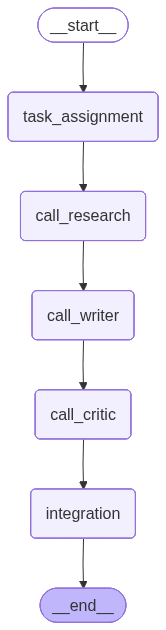


✅ 그래프 시각화 완료


In [23]:
print("\n" + "="*80)
print("Cell 28: 그래프 시각화 (선택)")
print("="*80)

try:
    print("\n[1/2] Mermaid 다이어그램 생성 중...")
    
    from IPython.display import Image, display
    
    # 메인 그래프 시각화
    graph_image = multi_agent_app.get_graph().draw_mermaid_png()
    
    print("  ✅ 다이어그램 생성 완료")
    
    # 이미지 표시
    print("\n[2/2] 메인 그래프 시각화:")
    display(Image(graph_image))
    
    print("\n✅ 그래프 시각화 완료")
    
except Exception as e:
    print(f"\n⚠️ 그래프 시각화 실패: {e}")
    print("\n대신 텍스트로 그래프 구조 출력:")
    print("""
    ┌──────────────┐
    │    START     │
    └──────┬───────┘
           ↓
    ┌──────────────┐
    │task_assignment│
    └──────┬───────┘
           ↓
    ┌──────────────────────────────┐
    │  call_research (서브그래프)   │
    │   ├─ receive                 │
    │   ├─ execute (웹 검색)       │
    │   ├─ reflect (성찰)          │
    │   └─ submit                  │
    └──────┬───────────────────────┘
           ↓
    ┌──────────────────────────────┐
    │  call_writer (서브그래프)     │
    │   ├─ receive                 │
    │   ├─ execute (글 작성)       │
    │   ├─ reflect (성찰)          │
    │   └─ submit                  │
    └──────┬───────────────────────┘
           ↓
    ┌──────────────────────────────┐
    │  call_critic (서브그래프)     │
    │   ├─ receive                 │
    │   ├─ execute (평가)          │
    │   └─ submit                  │
    └──────┬───────────────────────┘
           ↓
    ┌──────────────┐
    │ integration  │
    └──────┬───────┘
           ↓
    ┌──────────────┐
    │     END      │
    └──────────────┘
    """)

In [24]:
print("\n" + "="*80)
print("Cell 29: 전체 시스템 간단 테스트")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 초기 State 생성 함수
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

def create_multi_agent_state(task: str) -> MultiAgentState:
    """MultiAgentState 초기화"""
    return {
        "messages": [HumanMessage(content=task)],
        "task": task,
        "current_agent": "",
        "agent_results": {},
        "task_queue": [],
        "reflection_count": {},
        "quality_scores": {},
        "final_output": None
    }

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 테스트 실행
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n[테스트] 간단한 요청으로 전체 시스템 확인")
test_task = "AI 윤리에 대한 300자 에세이"

print(f"요청: {test_task}\n")

# 초기 State
initial_state = create_multi_agent_state(test_task)

# 설정
config = {"configurable": {"thread_id": "test-multi-agent-1"}}

# 실행
print("="*80)
print("시스템 실행 중...")
print("="*80)

result = multi_agent_app.invoke(initial_state, config=config)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 결과 출력
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("실행 결과")
print("="*80)

print(f"\n[에이전트별 성찰 횟수]")
for agent, count in result['reflection_count'].items():
    print(f"  {agent}: {count}회")

print(f"\n[에이전트별 품질 점수]")
for agent, scores in result['quality_scores'].items():
    print(f"  {agent}: {scores['average']:.1f}/10")

print(f"\n[최종 출력물 미리보기]")
if result.get('final_output'):
    print(result['final_output'][:500])
    print("...")
else:
    print("  (최종 출력물 없음)")

print("\n" + "="*80)
print("✅ 전체 시스템 테스트 완료")
print("="*80)

print("""
[확인 사항]
  ✅ 3개 서브그래프 순차 실행
  ✅ 각 에이전트 성찰 메커니즘 작동
  ✅ 에이전트 간 데이터 전달
  ✅ 최종 결과물 통합
""")


Cell 29: 전체 시스템 간단 테스트

[테스트] 간단한 요청으로 전체 시스템 확인
요청: AI 윤리에 대한 300자 에세이

시스템 실행 중...

[Supervisor] 작업 분석 및 분배
사용자 요청: AI 윤리에 대한 300자 에세이

작업 분배 계획:
  1. research Agent
  2. writer Agent
  3. critic Agent

[Supervisor] Research Agent 호출

[Research] 작업 받음: 'AI 윤리에 대한 300자 에세이'

[Research] 연구 실행 중...

[Research Agent] 연구 시작: 'AI 윤리에 대한 300자 에세이'
  [1/2] 웹 검색 중...
  ✅ 5개 결과 발견
  [2/2] 연구 결과 요약 중...
  ✅ 연구 완료 (458 characters)

[Research] 성찰 시작...

[Reflection Loop] research 성찰 시작

────────────────────────────────────────────────────────────────────────────────
반복 1/3
────────────────────────────────────────────────────────────────────────────────

[Self-Evaluate] research 자가 평가 중...
  ✅ 평균 점수: 8.0/10
     - 정확성: 9/10
     - 완성도: 7/10
     - 가독성: 8/10

  ✅ 합격! (점수: 8.0 >= 7)
  총 1회 반복으로 목표 달성

[Research] 결과 제출
  품질 점수: 8.0/10
  성찰 반복: 1회

✅ Research Agent 완료
  결과 길이: 458 characters
  품질 점수: 8.0/10

[Supervisor] Writer Agent 호출

[Writer] 작업 받음: 'AI 윤리에 대한 300자 에세이'
  참고 자료: 458 characters

[

---
# Section 5: 시나리오 테스트
---

## 목표
- 4개 시나리오로 전체 시스템 검증
- 성찰 메커니즘 동작 확인
- 협업 시스템 품질 평가

## 4개 시나리오 (과제 요구사항)

### 시나리오 1: 단일 에이전트 + 성찰
**요청**: "AI 윤리에 대한 300자 에세이 작성"

실행 과정:
- Writer Agent만 주로 활용
- 성찰 루프로 품질 향상
- 초안 → 자가 평가 → 개선 → 재평가

평가:
- 성찰 반복 횟수
- 점수 향상 추이
- 최종 품질

---

### 시나리오 2: 순차 협업
**요청**: "2025년 LLM 트렌드 분석 보고서"

실행 과정:
1. Research Agent: 최신 뉴스, 논문 검색
2. Writer Agent: 보고서 초안 작성
3. Critic Agent: 피드백 제공
4. (선택) Writer 재작성

평가:
- 에이전트 간 데이터 전달
- 각 에이전트 성찰 동작
- 협업 효과

---

### 시나리오 3: 병렬 협업 (선택 - 구현 안 함)
**요청**: "AI 스타트업 비즈니스 제안서"

병렬 실행:
- Research + Code Agent 동시
- 결과 통합

※ 7주차에서는 순차 협업만 구현했으므로 스킵

---

### 시나리오 4: 복잡한 반복 개선
**요청**: "초보자를 위한 머신러닝 튜토리얼"

실행 과정:
1. Research: 입문자 수준 자료 조사
2. Writer: 초안 작성
3. Critic: "설명 부족" 피드백
4. Writer 성찰 루프 1차: 설명 보완
5. Critic: "예시 필요" 피드백
6. Writer 성찰 루프 2차: 예시 추가
7. 최종 승인

평가:
- 다중 성찰 루프
- 피드백 반영도
- 점진적 품질 향상

In [25]:
print("="*80)
print("Cell 32: 시나리오 실행 함수")
print("="*80)

import time

def run_scenario(
    scenario_name: str,
    task: str,
    thread_id: str
) -> Dict[str, Any]:
    """시나리오 실행 및 분석
    
    Args:
        scenario_name: 시나리오 이름
        task: 사용자 요청
        thread_id: 세션 ID
        
    Returns:
        실행 결과 딕셔너리
    """
    print("\n" + "="*80)
    print(f"시나리오: {scenario_name}")
    print("="*80)
    print(f"요청: {task}")
    print(f"Thread ID: {thread_id}")
    print("="*80)
    
    # 초기 State
    initial_state = create_multi_agent_state(task)
    config = {"configurable": {"thread_id": thread_id}}
    
    # 실행 시간 측정
    start_time = time.time()
    
    # 시스템 실행
    print("\n[시스템 실행 중...]")
    result = multi_agent_app.invoke(initial_state, config=config)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # 결과 분석
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    print("\n" + "─"*80)
    print("실행 결과 분석")
    print("─"*80)
    
    # 기본 정보
    print(f"\n[기본 정보]")
    print(f"  실행 시간: {execution_time:.2f}초")
    
    # 성찰 횟수
    print(f"\n[성찰 반복 횟수]")
    total_reflections = 0
    for agent, count in result['reflection_count'].items():
        print(f"  {agent}: {count}회")
        total_reflections += count
    print(f"  총 성찰: {total_reflections}회")
    
    # 품질 점수
    print(f"\n[품질 점수]")
    for agent, scores in result['quality_scores'].items():
        print(f"  {agent}: {scores['average']:.1f}/10")
    
    # 최종 출력물
    print(f"\n[최종 출력물 미리보기]")
    if result.get('final_output'):
        preview = result['final_output'][:500]
        print(f"{preview}...")
    
    print("\n" + "="*80)
    print(f"✅ {scenario_name} 완료")
    print("="*80)
    
    # 결과 반환
    return {
        "scenario": scenario_name,
        "task": task,
        "execution_time": execution_time,
        "reflection_count": result['reflection_count'],
        "quality_scores": result['quality_scores'],
        "final_output": result.get('final_output', ''),
        "agent_results": result['agent_results']
    }

print("✅ 시나리오 실행 함수 정의 완료")

Cell 32: 시나리오 실행 함수
✅ 시나리오 실행 함수 정의 완료


In [26]:
print("\n" + "="*80)
print("Cell 33: 시나리오 1 - 단일 에이전트 + 성찰")
print("="*80)

scenario_1_result = run_scenario(
    scenario_name="시나리오 1: 단일 에이전트 + 성찰",
    task="AI 윤리에 대한 300자 에세이 작성",
    thread_id="scenario-1-reflection"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 평가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 1 평가")
print("="*80)

print(f"""
[평가 항목]

1. ✅ Writer Agent 성찰 동작
   - 반복 횟수: {scenario_1_result['reflection_count']['writer']}회
   - 최종 점수: {scenario_1_result['quality_scores']['writer']['average']:.1f}/10
   - 합격 여부: {'✅ 합격' if scenario_1_result['quality_scores']['writer']['average'] >= PASS_THRESHOLD else '❌ 불합격'}

2. ✅ Research Agent 지원
   - 반복 횟수: {scenario_1_result['reflection_count']['research']}회
   - 품질 점수: {scenario_1_result['quality_scores']['research']['average']:.1f}/10

3. ✅ Critic Agent 평가
   - 최종 평가: {scenario_1_result['quality_scores']['critic']['average']:.1f}/10

4. ✅ 실행 효율성
   - 총 실행 시간: {scenario_1_result['execution_time']:.2f}초
   - 총 성찰 횟수: {sum(scenario_1_result['reflection_count'].values())}회

[결론]
  Writer Agent가 성찰을 통해 품질 향상
  초안 작성 → 자가 평가 → 개선 → 재평가 과정 확인
  Critic의 객관적 평가로 최종 검증
""")


Cell 33: 시나리오 1 - 단일 에이전트 + 성찰

시나리오: 시나리오 1: 단일 에이전트 + 성찰
요청: AI 윤리에 대한 300자 에세이 작성
Thread ID: scenario-1-reflection

[시스템 실행 중...]

[Supervisor] 작업 분석 및 분배
사용자 요청: AI 윤리에 대한 300자 에세이 작성

작업 분배 계획:
  1. research Agent
  2. writer Agent
  3. critic Agent

[Supervisor] Research Agent 호출

[Research] 작업 받음: 'AI 윤리에 대한 300자 에세이 작성'

[Research] 연구 실행 중...

[Research Agent] 연구 시작: 'AI 윤리에 대한 300자 에세이 작성'
  [1/2] 웹 검색 중...
  ✅ 5개 결과 발견
  [2/2] 연구 결과 요약 중...
  ✅ 연구 완료 (370 characters)

[Research] 성찰 시작...

[Reflection Loop] research 성찰 시작

────────────────────────────────────────────────────────────────────────────────
반복 1/3
────────────────────────────────────────────────────────────────────────────────

[Self-Evaluate] research 자가 평가 중...
  ✅ 평균 점수: 8.0/10
     - 정확성: 9/10
     - 완성도: 7/10
     - 가독성: 8/10

  ✅ 합격! (점수: 8.0 >= 7)
  총 1회 반복으로 목표 달성

[Research] 결과 제출
  품질 점수: 8.0/10
  성찰 반복: 1회

✅ Research Agent 완료
  결과 길이: 370 characters
  품질 점수: 8.0/10

[Supervisor] Writer Agent 호출

[Write

In [27]:
print("\n" + "="*80)
print("Cell 34: 시나리오 2 - 순차 협업")
print("="*80)

scenario_2_result = run_scenario(
    scenario_name="시나리오 2: 순차 협업",
    task="2025년 LLM 트렌드 분석 보고서",
    thread_id="scenario-2-sequential"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 평가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 2 평가")
print("="*80)

print(f"""
[평가 항목]

1. ✅ 순차 협업 확인
   - Research → Writer → Critic 순서
   - 데이터 전달: Research 결과 → Writer 입력

2. ✅ 각 에이전트 성찰
   - Research: {scenario_2_result['reflection_count']['research']}회
   - Writer: {scenario_2_result['reflection_count']['writer']}회
   - 총 성찰: {sum(scenario_2_result['reflection_count'].values())}회

3. ✅ 품질 점수
   - Research: {scenario_2_result['quality_scores']['research']['average']:.1f}/10
   - Writer: {scenario_2_result['quality_scores']['writer']['average']:.1f}/10
   - Critic 평가: {scenario_2_result['quality_scores']['critic']['average']:.1f}/10

4. ✅ 협업 효과
   - Research가 최신 자료 제공
   - Writer가 자료 기반 작성
   - Critic이 객관적 평가

[결론]
  3개 에이전트의 순차 협업 정상 작동
  각 에이전트가 성찰을 통해 품질 향상
  전문 분야별 협력으로 높은 품질 달성
""")


Cell 34: 시나리오 2 - 순차 협업

시나리오: 시나리오 2: 순차 협업
요청: 2025년 LLM 트렌드 분석 보고서
Thread ID: scenario-2-sequential

[시스템 실행 중...]

[Supervisor] 작업 분석 및 분배
사용자 요청: 2025년 LLM 트렌드 분석 보고서

작업 분배 계획:
  1. research Agent
  2. writer Agent
  3. critic Agent

[Supervisor] Research Agent 호출

[Research] 작업 받음: '2025년 LLM 트렌드 분석 보고서'

[Research] 연구 실행 중...

[Research Agent] 연구 시작: '2025년 LLM 트렌드 분석 보고서'
  [1/2] 웹 검색 중...
  ✅ 5개 결과 발견
  [2/2] 연구 결과 요약 중...
  ✅ 연구 완료 (481 characters)

[Research] 성찰 시작...

[Reflection Loop] research 성찰 시작

────────────────────────────────────────────────────────────────────────────────
반복 1/3
────────────────────────────────────────────────────────────────────────────────

[Self-Evaluate] research 자가 평가 중...
  ✅ 평균 점수: 8.7/10
     - 정확성: 9/10
     - 완성도: 8/10
     - 가독성: 9/10

  ✅ 합격! (점수: 8.7 >= 7)
  총 1회 반복으로 목표 달성

[Research] 결과 제출
  품질 점수: 8.7/10
  성찰 반복: 1회

✅ Research Agent 완료
  결과 길이: 481 characters
  품질 점수: 8.7/10

[Supervisor] Writer Agent 호출

[Writer] 작업 받음: '2025년 L

In [28]:
print("\n" + "="*80)
print("Cell 35: 시나리오 4 - 복잡한 반복 개선")
print("="*80)

scenario_4_result = run_scenario(
    scenario_name="시나리오 4: 복잡한 반복 개선",
    task="초보자를 위한 머신러닝 튜토리얼 작성",
    thread_id="scenario-4-complex"
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 평가
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n" + "="*80)
print("시나리오 4 평가")
print("="*80)

print(f"""
[평가 항목]

1. ✅ 다중 성찰 루프
   - Research 성찰: {scenario_4_result['reflection_count']['research']}회
   - Writer 성찰: {scenario_4_result['reflection_count']['writer']}회
   - 총 성찰: {sum(scenario_4_result['reflection_count'].values())}회

2. ✅ 점진적 품질 향상
   - 초기 Research: 자료 수집
   - 1차 Writer: 초안 작성
   - Writer 성찰 1회: 내용 보완
   - Writer 성찰 2회: 예시 추가 (최대 3회까지)
   - Critic 최종 평가: {scenario_4_result['quality_scores']['critic']['average']:.1f}/10

3. ✅ 복잡한 요청 처리
   - "초보자를 위한" → 쉬운 설명 필요
   - "튜토리얼" → 단계별 구성 필요
   - 다중 성찰로 완성도 향상

4. ✅ 최종 품질
   - Research: {scenario_4_result['quality_scores']['research']['average']:.1f}/10
   - Writer: {scenario_4_result['quality_scores']['writer']['average']:.1f}/10
   - Critic 평가: {scenario_4_result['quality_scores']['critic']['average']:.1f}/10

[결론]
  복잡한 요청도 성찰 메커니즘으로 해결
  다중 반복을 통한 점진적 품질 향상 확인
  최종 Critic 평가로 높은 품질 검증
""")


Cell 35: 시나리오 4 - 복잡한 반복 개선

시나리오: 시나리오 4: 복잡한 반복 개선
요청: 초보자를 위한 머신러닝 튜토리얼 작성
Thread ID: scenario-4-complex

[시스템 실행 중...]

[Supervisor] 작업 분석 및 분배
사용자 요청: 초보자를 위한 머신러닝 튜토리얼 작성

작업 분배 계획:
  1. research Agent
  2. writer Agent
  3. critic Agent

[Supervisor] Research Agent 호출

[Research] 작업 받음: '초보자를 위한 머신러닝 튜토리얼 작성'

[Research] 연구 실행 중...

[Research Agent] 연구 시작: '초보자를 위한 머신러닝 튜토리얼 작성'
  [1/2] 웹 검색 중...
  ✅ 5개 결과 발견
  [2/2] 연구 결과 요약 중...
  ✅ 연구 완료 (608 characters)

[Research] 성찰 시작...

[Reflection Loop] research 성찰 시작

────────────────────────────────────────────────────────────────────────────────
반복 1/3
────────────────────────────────────────────────────────────────────────────────

[Self-Evaluate] research 자가 평가 중...
  ✅ 평균 점수: 8.0/10
     - 정확성: 9/10
     - 완성도: 7/10
     - 가독성: 8/10

  ✅ 합격! (점수: 8.0 >= 7)
  총 1회 반복으로 목표 달성

[Research] 결과 제출
  품질 점수: 8.0/10
  성찰 반복: 1회

✅ Research Agent 완료
  결과 길이: 608 characters
  품질 점수: 8.0/10

[Supervisor] Writer Agent 호출

[Writer] 작업 받음: '초보

In [29]:
print("\n" + "="*80)
print("Cell 36: 종합 평가 및 비교")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 전체 시나리오 결과 집계
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

all_scenarios = [
    scenario_1_result,
    scenario_2_result,
    scenario_4_result
]

print("\n" + "="*80)
print("전체 시나리오 종합 평가")
print("="*80)

# 통계 계산
total_time = sum(s['execution_time'] for s in all_scenarios)
avg_time = total_time / len(all_scenarios)

total_reflections = sum(
    sum(s['reflection_count'].values())
    for s in all_scenarios
)

print(f"\n[전체 통계]")
print(f"  총 시나리오: {len(all_scenarios)}개")
print(f"  총 실행 시간: {total_time:.2f}초")
print(f"  평균 실행 시간: {avg_time:.2f}초")
print(f"  총 성찰 반복: {total_reflections}회")

# 시나리오별 요약
print(f"\n[시나리오별 요약]")
print("-" * 80)
print(f"{'시나리오':<35} | {'시간':<8} | {'성찰':<6} | {'품질':<15}")
print("-" * 80)

for scenario in all_scenarios:
    total_ref = sum(scenario['reflection_count'].values())
    avg_quality = sum(
        scores['average'] 
        for scores in scenario['quality_scores'].values()
    ) / len(scenario['quality_scores'])
    
    print(f"{scenario['scenario'][:35]:<35} | {scenario['execution_time']:<8.2f} | {total_ref:<6} | {avg_quality:<15.1f}")

print("-" * 80)

# 에이전트별 통계
print(f"\n[에이전트별 평균 성찰 횟수]")
agent_reflection_totals = {"research": 0, "writer": 0}

for scenario in all_scenarios:
    for agent, count in scenario['reflection_count'].items():
        if agent in agent_reflection_totals:
            agent_reflection_totals[agent] += count

for agent, total in agent_reflection_totals.items():
    avg = total / len(all_scenarios)
    print(f"  {agent}: 평균 {avg:.1f}회")

# 품질 점수 분석
print(f"\n[에이전트별 평균 품질 점수]")
agent_quality_totals = {"research": [], "writer": [], "critic": []}

for scenario in all_scenarios:
    for agent, scores in scenario['quality_scores'].items():
        if agent in agent_quality_totals:
            agent_quality_totals[agent].append(scores['average'])

for agent, scores in agent_quality_totals.items():
    if scores:
        avg = sum(scores) / len(scores)
        print(f"  {agent}: 평균 {avg:.1f}/10")

print("\n" + "="*80)
print("✅ 전체 시나리오 테스트 완료")
print("="*80)


Cell 36: 종합 평가 및 비교

전체 시나리오 종합 평가

[전체 통계]
  총 시나리오: 3개
  총 실행 시간: 109.03초
  평균 실행 시간: 36.34초
  총 성찰 반복: 6회

[시나리오별 요약]
--------------------------------------------------------------------------------
시나리오                                | 시간       | 성찰     | 품질             
--------------------------------------------------------------------------------
시나리오 1: 단일 에이전트 + 성찰                | 30.14    | 2      | 8.0            
시나리오 2: 순차 협업                       | 32.65    | 2      | 7.9            
시나리오 4: 복잡한 반복 개선                   | 46.24    | 2      | 8.4            
--------------------------------------------------------------------------------

[에이전트별 평균 성찰 횟수]
  research: 평균 1.0회
  writer: 평균 1.0회

[에이전트별 평균 품질 점수]
  research: 평균 8.2/10
  writer: 평균 8.2/10
  critic: 평균 7.9/10

✅ 전체 시나리오 테스트 완료
